In [69]:
%matplotlib notebook

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from icecream import ic
import STOM_higgs_tools
np.random.seed(1)

In [71]:
def exponential_distribution(x: np.ndarray, A: float, lamb: float) -> np.ndarray:
    #Exponential distribution function for background events.

    return A * np.exp(-x/lamb)


def gaussian_distribution(x: np.ndarray, B: float, mu: float, sigma: float) -> np.ndarray:
    #Gaussian distribution function for signal events. 
    return B * np.exp(-(x-mu)**2 / (2*sigma**2))


def combined_distribution(x: np.ndarray, *params) -> np.ndarray:
    #Combined distribution of exponential background and Gaussian signal.
    A, lamb, B, mu, sigma = params
    return exponential_distribution(x, A, lamb) + gaussian_distribution(x, B, mu, sigma)


 # Task 1

<IPython.core.display.Javascript object>

/var/folders/rv/n60z7tpj7z7d9f_gyq2v677w0000gn/T/ipykernel_35875/3995917896.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


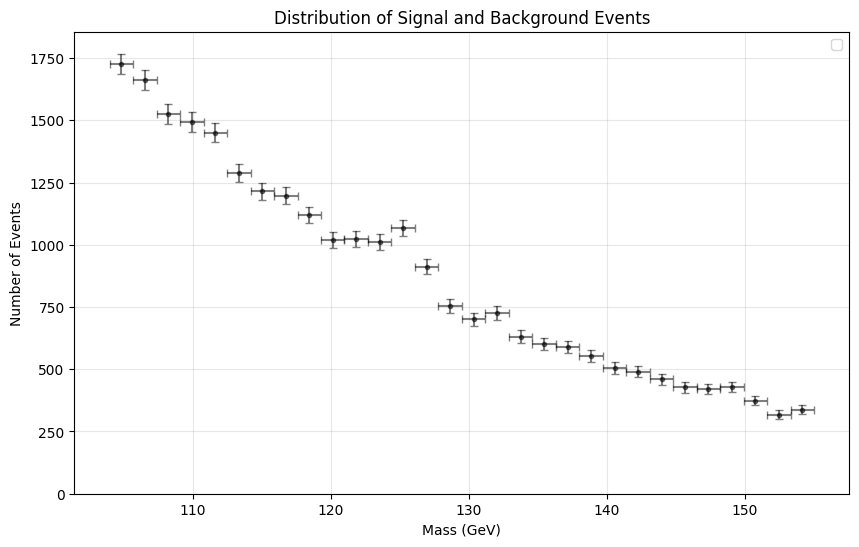

In [72]:

# Generate and prepare data
# Generate and prepare data
amplitude_values = np.array(STOM_higgs_tools.generate_data())

# Define histogram parameters
AMPLITUDE_RANGE = (104, 155)
NUM_BINS = 30

# Create histogram
fig, ax = plt.subplots(figsize=(10, 6))

# plt.hist returns bin_heights, bin_edges, patches
# where bin_heights is the number of events in each bin
# bin_edges is the coordinates of the bin edges
bin_heights, bin_edges, _ = ax.hist(
    amplitude_values, 
    bins=NUM_BINS, 
    alpha=0, 
    color='blue', 
    edgecolor='black', 
    range=AMPLITUDE_RANGE
)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
uncertainties = np.sqrt(bin_heights)  # Poisson uncertainty

bin_width = bin_edges[1] - bin_edges[0]
x_uncertainties = bin_width / 2
# Plot error bars
ax.errorbar(
    bin_centers, 
    bin_heights, 
    yerr=uncertainties, 
    xerr=x_uncertainties, 
    fmt='k.', 
    capsize=3, 
    alpha=0.5
)
# Customize plot
ax.set_xlabel('Mass (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title('Distribution of Signal and Background Events')
ax.grid(True, alpha=0.3)
ax.legend()
display(fig)

# Task 2

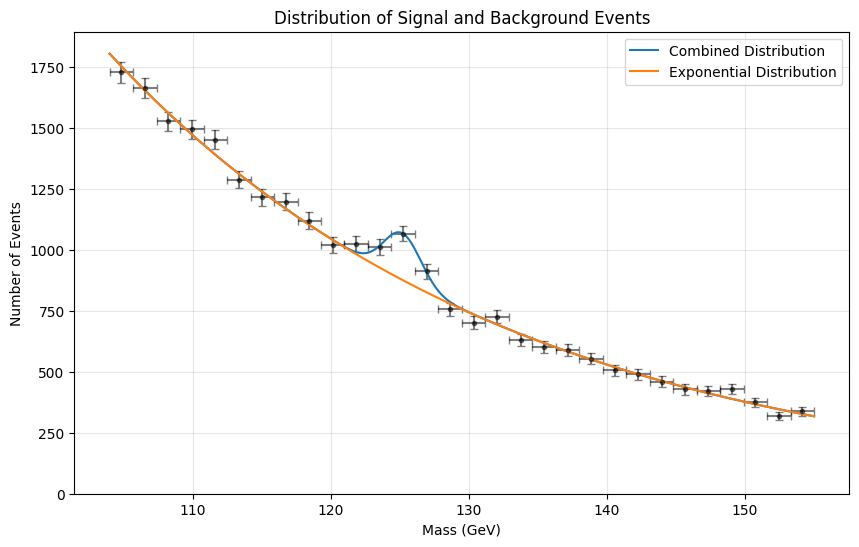

In [73]:

# Estimate background parameters this is perceived between the two vertical lines in the histogram
SIGNAL_REGION = (121, 128)
background_values = np.concatenate((
    amplitude_values[amplitude_values < SIGNAL_REGION[0]],
    amplitude_values[amplitude_values > SIGNAL_REGION[1]]
))
bin_heights_signal = bin_heights[
    (bin_centers >= SIGNAL_REGION[0]) & 
    (bin_centers <= SIGNAL_REGION[1])
]
bin_centers_signal = bin_centers[
    (bin_centers >= SIGNAL_REGION[0]) & 
    (bin_centers <= SIGNAL_REGION[1])
]
# finding the index of the peak of the bin_heights_signal and using that as gaussian mean
peak_index,_ = find_peaks(bin_heights_signal)
mu_estimate = bin_centers_signal[peak_index[0]]
# take sigma as the standard deviation of the histogram within the signal range
sigma_estimate = np.std(bin_centers_signal)

# Estimate lambda for exponential background
lamb_estimate = np.sum(background_values) / len(background_values)

# Calculate amplitude for exponential background
# by taking an integration of the background distribution over the mass range
# and dividing by the area under the histogram
area_under_histogram = np.sum(bin_heights) * bin_width
A_estimate = area_under_histogram / (
    lamb_estimate * 
    (np.exp(-AMPLITUDE_RANGE[0]/lamb_estimate) - 
        np.exp(-AMPLITUDE_RANGE[1]/lamb_estimate))
)
# B_estimate has been obtained by taking the height of the peak of the gaussian shape in the histogram
B_estimate = np.max(bin_heights)


# Initial parameter guesses for curve fitting
initial_params = [
    A_estimate,    # A
    lamb_estimate,  # lambda
    B_estimate,                 # B
    mu_estimate,              # mu
    sigma_estimate                  # sigma
]

# Perform curve fitting
fitted_params, _ = curve_fit(
    combined_distribution, 
    bin_centers, 
    bin_heights, 
    p0=initial_params
)

# Plot results
x_fine = np.linspace(*AMPLITUDE_RANGE, 1000)

# Plot combined distribution
ax.plot(
    x_fine, 
    combined_distribution(x_fine, *fitted_params),
    label='Combined Distribution'
)

# Plot background distribution
ax.plot(
    x_fine,
    exponential_distribution(x_fine, *fitted_params[:2]),
    label='Exponential Distribution'
)
ax.legend()
display(fig)